# Part 1

### Question 1 (задача о редкой группе крови)

### Question 2 (задача о редкой группе крови)

### Question 3 (задача о страшной болезни)

In [7]:
ILLNESS_PROB = 0.01

def calc_illness_prob(FN, FP):
    return (1 - FN) * ILLNESS_PROB / ((1 - FN) * ILLNESS_PROB + FP * (1 - ILLNESS_PROB))

assert round(calc_illness_prob(0.05, 0.05), 2) == 0.16

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 5)

x = np.linspace(0, 0.05, num = 100)

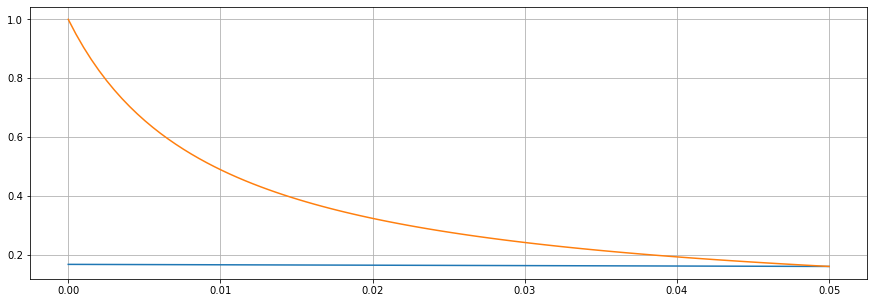

In [9]:
fig, ax = plt.subplots()
## FN
sns.lineplot(x, calc_illness_prob(x, 0.05), ax=ax)
## FP
sns.lineplot(x, calc_illness_prob(0.05, x), ax=ax)
ax.xaxis.grid(True) 
ax.yaxis.grid(True) 

### 3*

In [10]:
I = illness
T- = negative test 
P(I|T-) = P(T-|I) * P(I) / P(T-)
P(T-|I) = FN
P(T-|~I) = 1 - FP
P(T-) = P(T-|I) * P(I) + P(T-|~I) * P(~I) = FN * P(I) + (1 - FP) * P(~I)

SyntaxError: invalid syntax (<ipython-input-10-40a359904f78>, line 2)

In [11]:
ILLNESS_PROB = 0.01

def calc_illness_neg_test(FN, FP):
    return FN * ILLNESS_PROB / (FN * ILLNESS_PROB + (1 - FP) * (1 - ILLNESS_PROB))

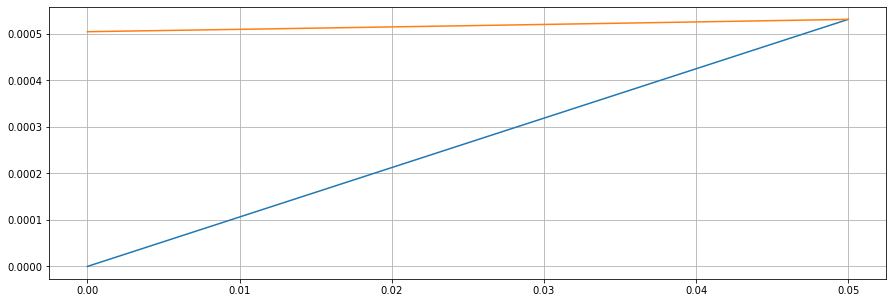

In [12]:
fig, ax = plt.subplots()
## FN
sns.lineplot(x, calc_illness_neg_test(x, 0.05), ax=ax)
## FP
sns.lineplot(x, calc_illness_neg_test(0.05, x), ax=ax)
ax.xaxis.grid(True) 
ax.yaxis.grid(True) 

# Part 2

### Дело в том, что что-то похожее я делал в марте прошлого года(для себя)
[ссылка на статью на дзене, где я строил регрессию с экспоненциальной зависимостью](https://zen.yandex.ru/media/id/5c7777a3edb9e500afc06642/chislo-inficirovannyh-koronavirusom-v-moskve-na-27-marta-5c7d543d29edf000af3ce0db)

In [244]:
df = pd.read_csv('covid-data.csv')
df = df[df.location == 'Russia']
df.date = pd.to_datetime(df.date)
df = df[df.date >= pd.to_datetime("2020-03-03")]
df['const'] = 1
df = df[['total_cases', 'new_cases', 'const', 'date']].reset_index(drop=True)
df['day'] = df.index
train = df.iloc[:50]
test = df.iloc[50:]
df.head()

,total_cases,new_cases,const,date,day
0,3.0,0.0,1,2020-03-03,0
1,3.0,0.0,1,2020-03-04,1
2,4.0,1.0,1,2020-03-05,2
3,13.0,9.0,1,2020-03-06,3
4,13.0,0.0,1,2020-03-07,4


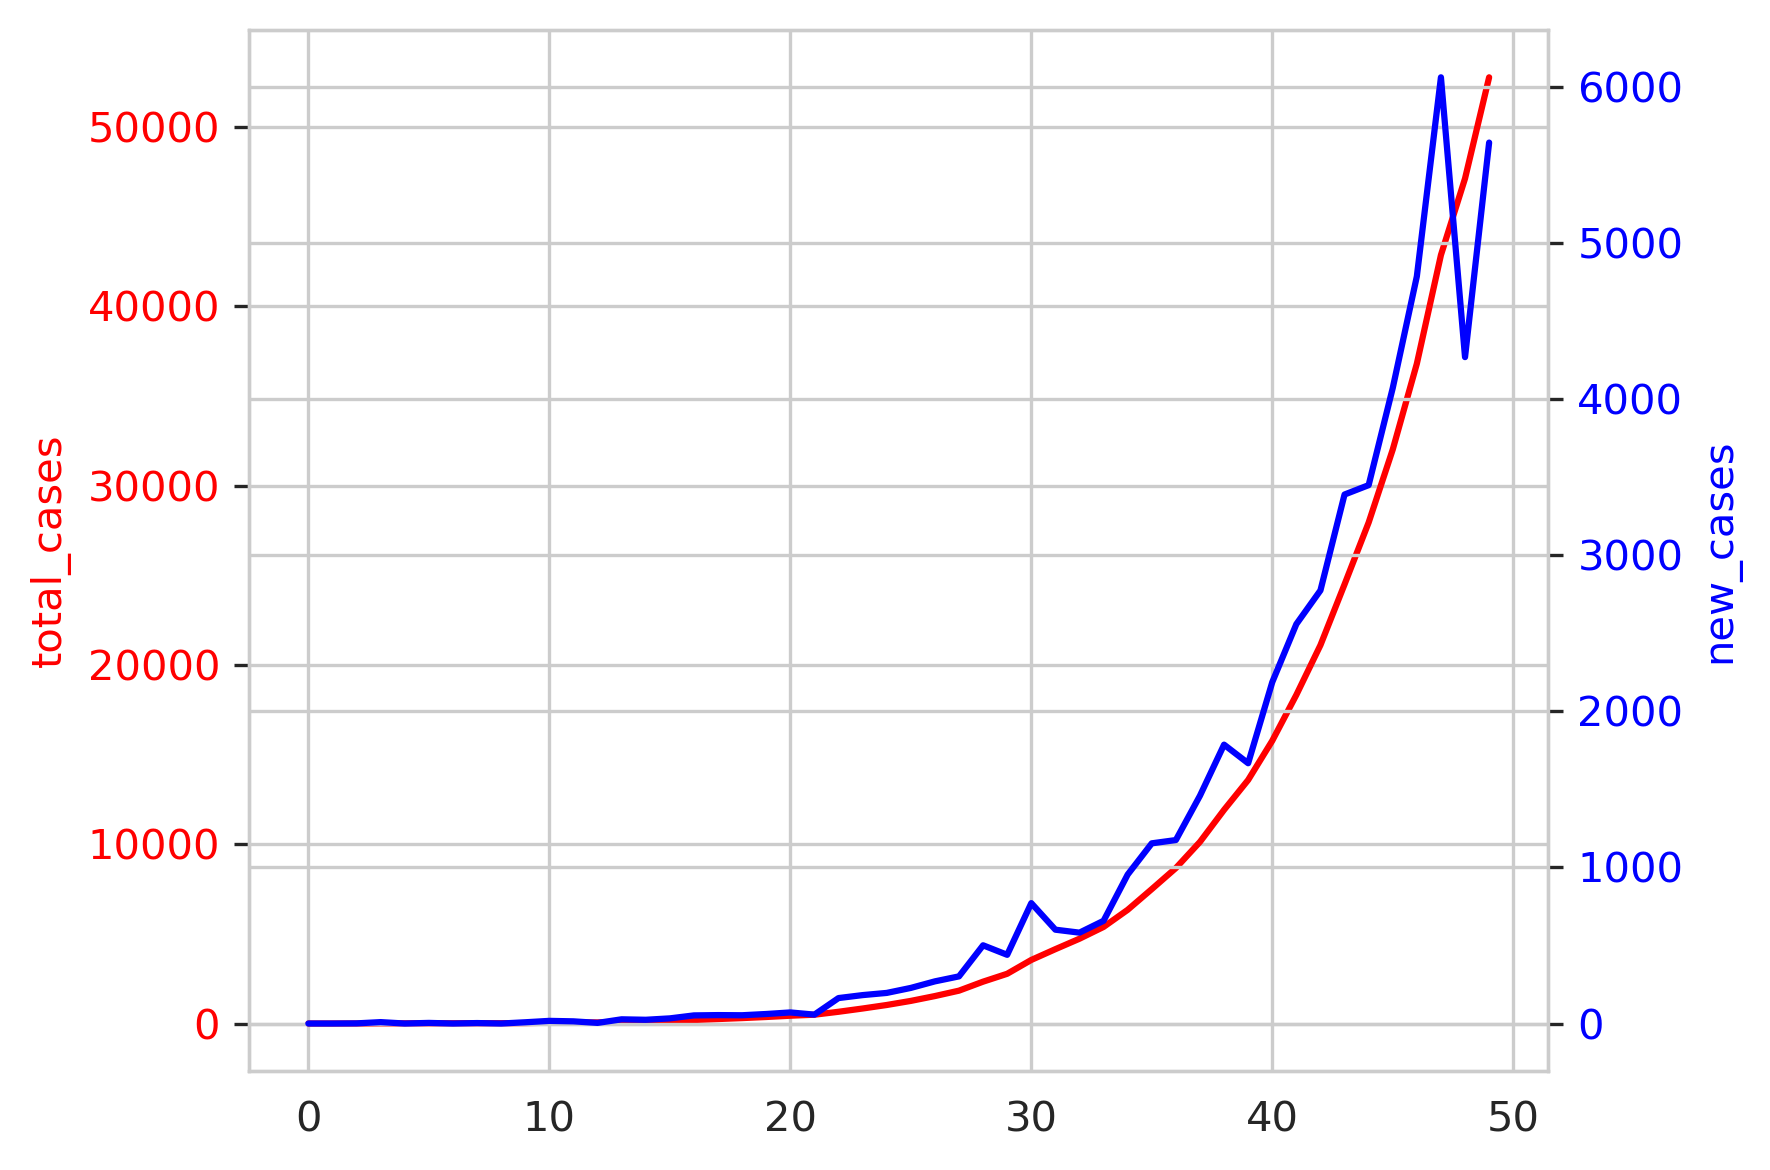

In [245]:
fig, ax1 = plt.subplots()
color='red'
ax1.set_ylabel('total_cases', color=color)
ax1.plot(train.index, train.total_cases, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  

color='blue'
ax2.set_ylabel('new_cases', color=color)
ax2.plot(train.index, train.new_cases, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
ax1.xaxis.grid(True) 
ax1.yaxis.grid(True) 

In [246]:
from sklearn.linear_model import Ridge

X_train = train[['day', 'const']]
y_train = np.log(train.total_cases)
model = Ridge(alpha = 0.1, fit_intercept=False)
model.fit(X_train, y_train)
model.coef_

array([0.19871412, 1.80675498])

In [247]:
#оценка байесовского шума
sigma_noise = np.std(y_train - model.predict(X_train))
sigma_noise

0.3490956324357155

In [248]:
#априорное распределение параметров
mean = [0, 0]
cov = [[1, 0], [0, 1]] 

In [249]:
def bayesian_update(mu, sigma, x_matrix, y, sigma_noise=.25):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix),
                                                                                       x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + 
                     (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), y) ) 
    return mu_n, sigma_n

In [250]:
new_mean, new_cov = bayesian_update(mean, cov, X_train, y_train, sigma_noise)
new_mean, new_cov

(array([0.1988058 , 1.80372609]),
 array([[ 1.16223981e-05, -2.84056406e-04],
        [-2.84056406e-04,  9.37388967e-03]]))

<AxesSubplot:xlabel='day', ylabel='total_cases'>

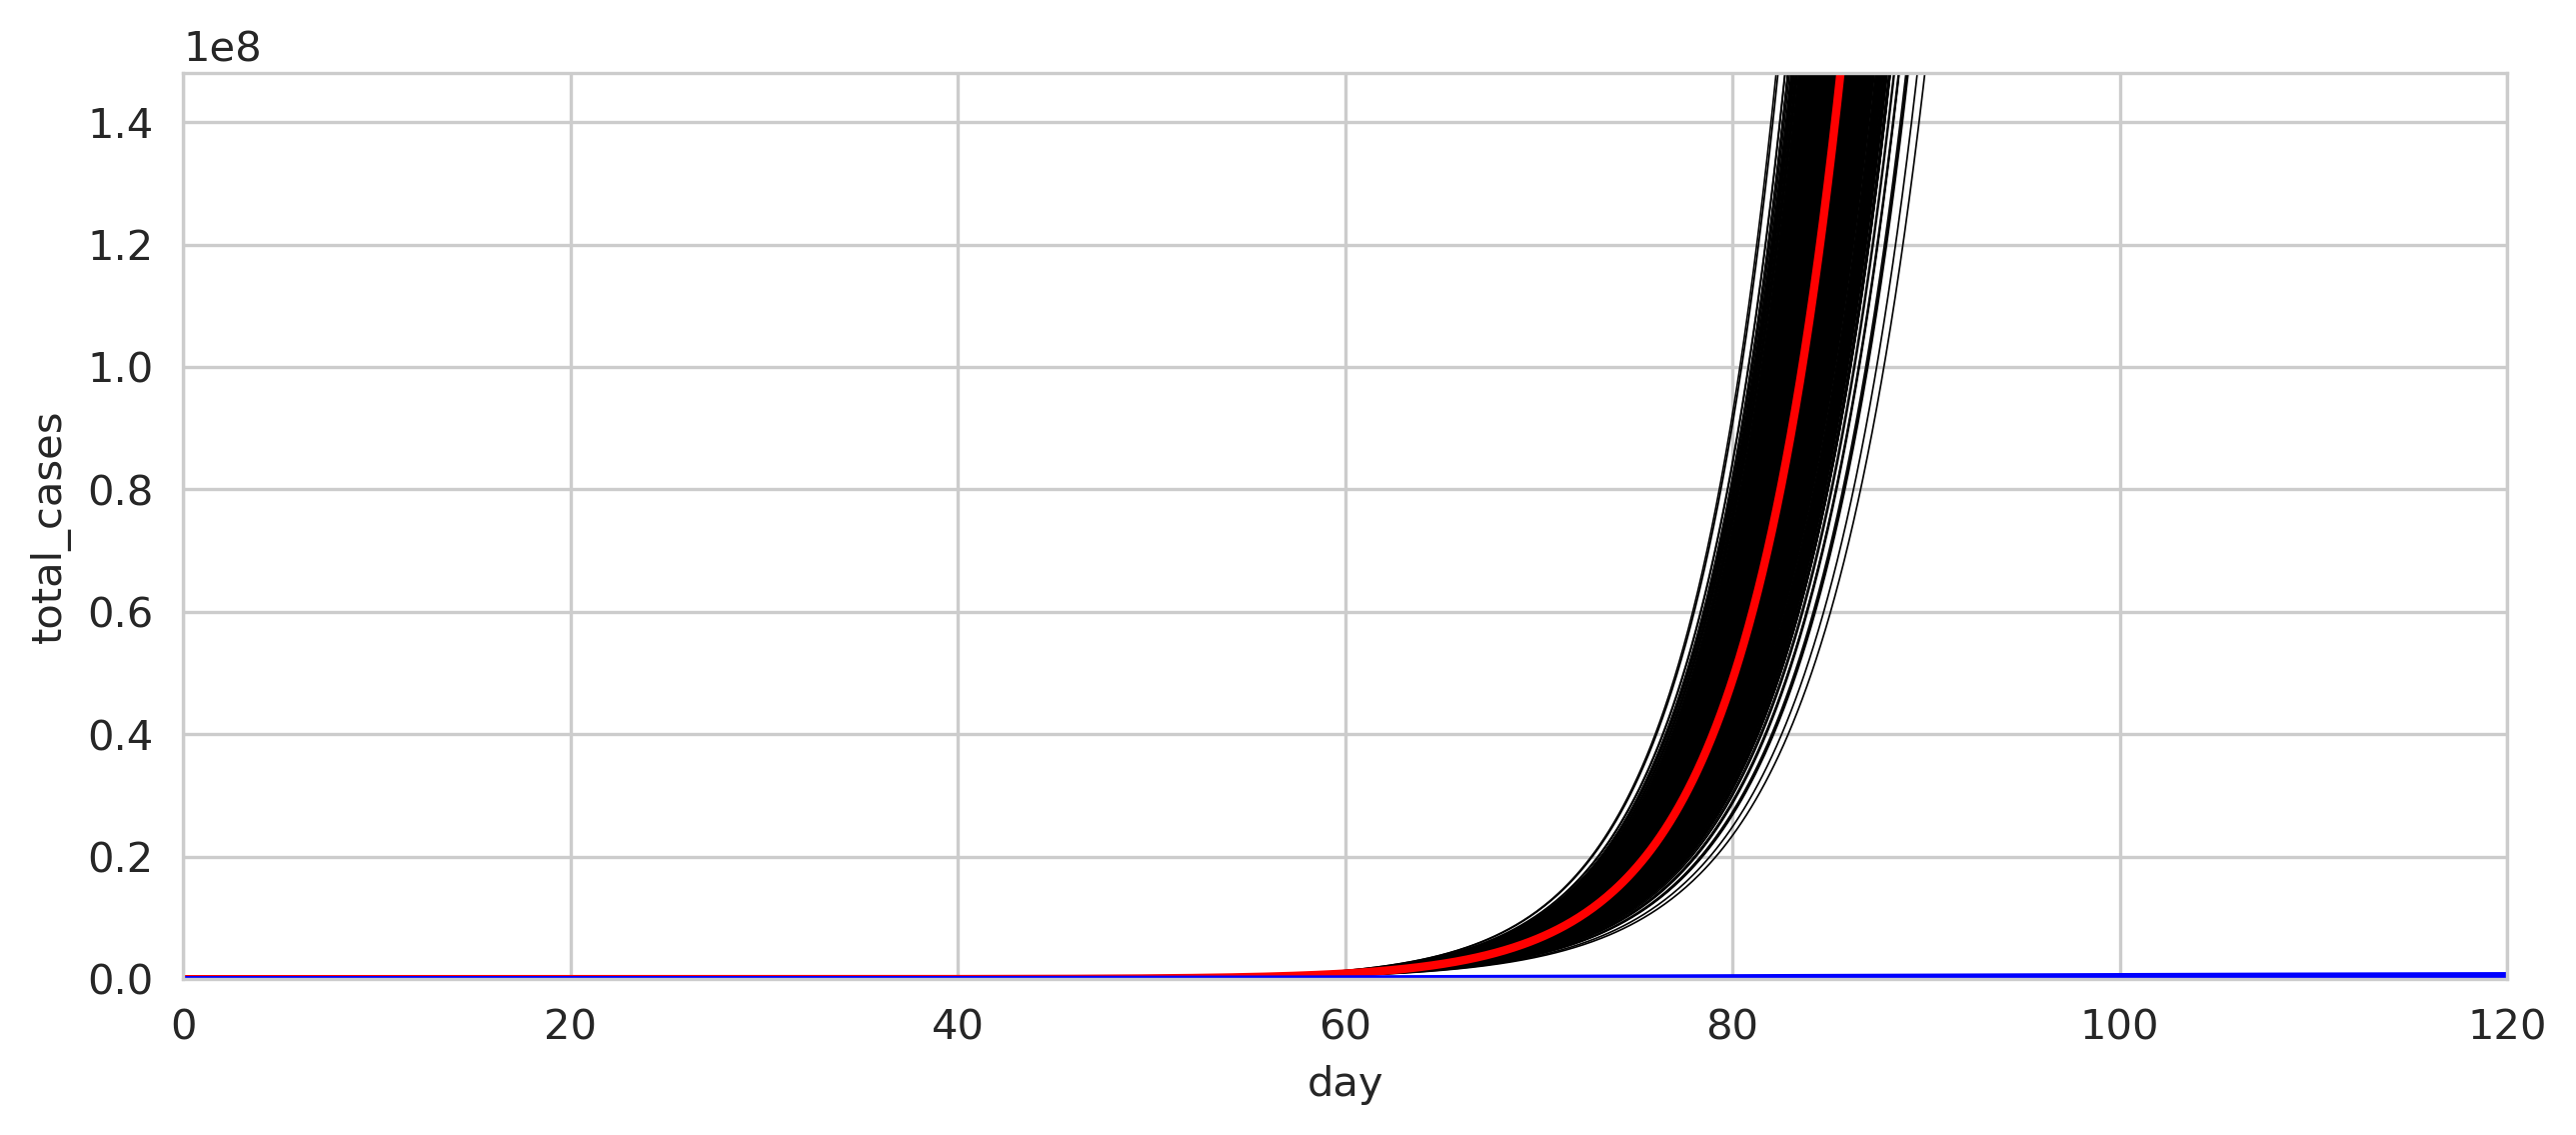

In [251]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
%matplotlib inline
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})

def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    # plt.axis('equal')
    for w in my_w:
        plt.plot(xs, np.exp(w[0]*xs + w[1]), 'k-', lw=.4)
    plt.ylim((0, 1.48e8))
    plt.xlim((0, 120))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)


xs = np.linspace(0, 120, 1000)
fig = plt.figure(figsize=(10, 4))
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((0, 5000))
myplot_sample_lines(new_mean, new_cov, n=1000)
#MLE prediction
plt.plot(xs, np.exp(model.coef_[0]*xs + model.coef_[1]), lw=2, color='red')
sns.lineplot(data=df, x="day", y="total_cases", color='blue')

In [252]:
def get_pred(date):
    day = df[df.date == pd.to_datetime(date)].day
    pred = round(np.mean([np.exp(w[0]*day + w[1]) for w in my_w]))
    print(date, day, pred)
                                       

my_w = np.random.multivariate_normal(new_mean, new_cov, 1000)
dates = ['2020-05-01', '2020-06-01', '2020-09-01']

for date in dates:
    get_pred(date)

2020-05-01 59    59
Name: day, dtype: int64 761348
2020-06-01 90    90
Name: day, dtype: int64 368822772
2020-09-01 182    182
Name: day, dtype: int64 36611005147838256


<AxesSubplot:xlabel='day', ylabel='total_cases'>

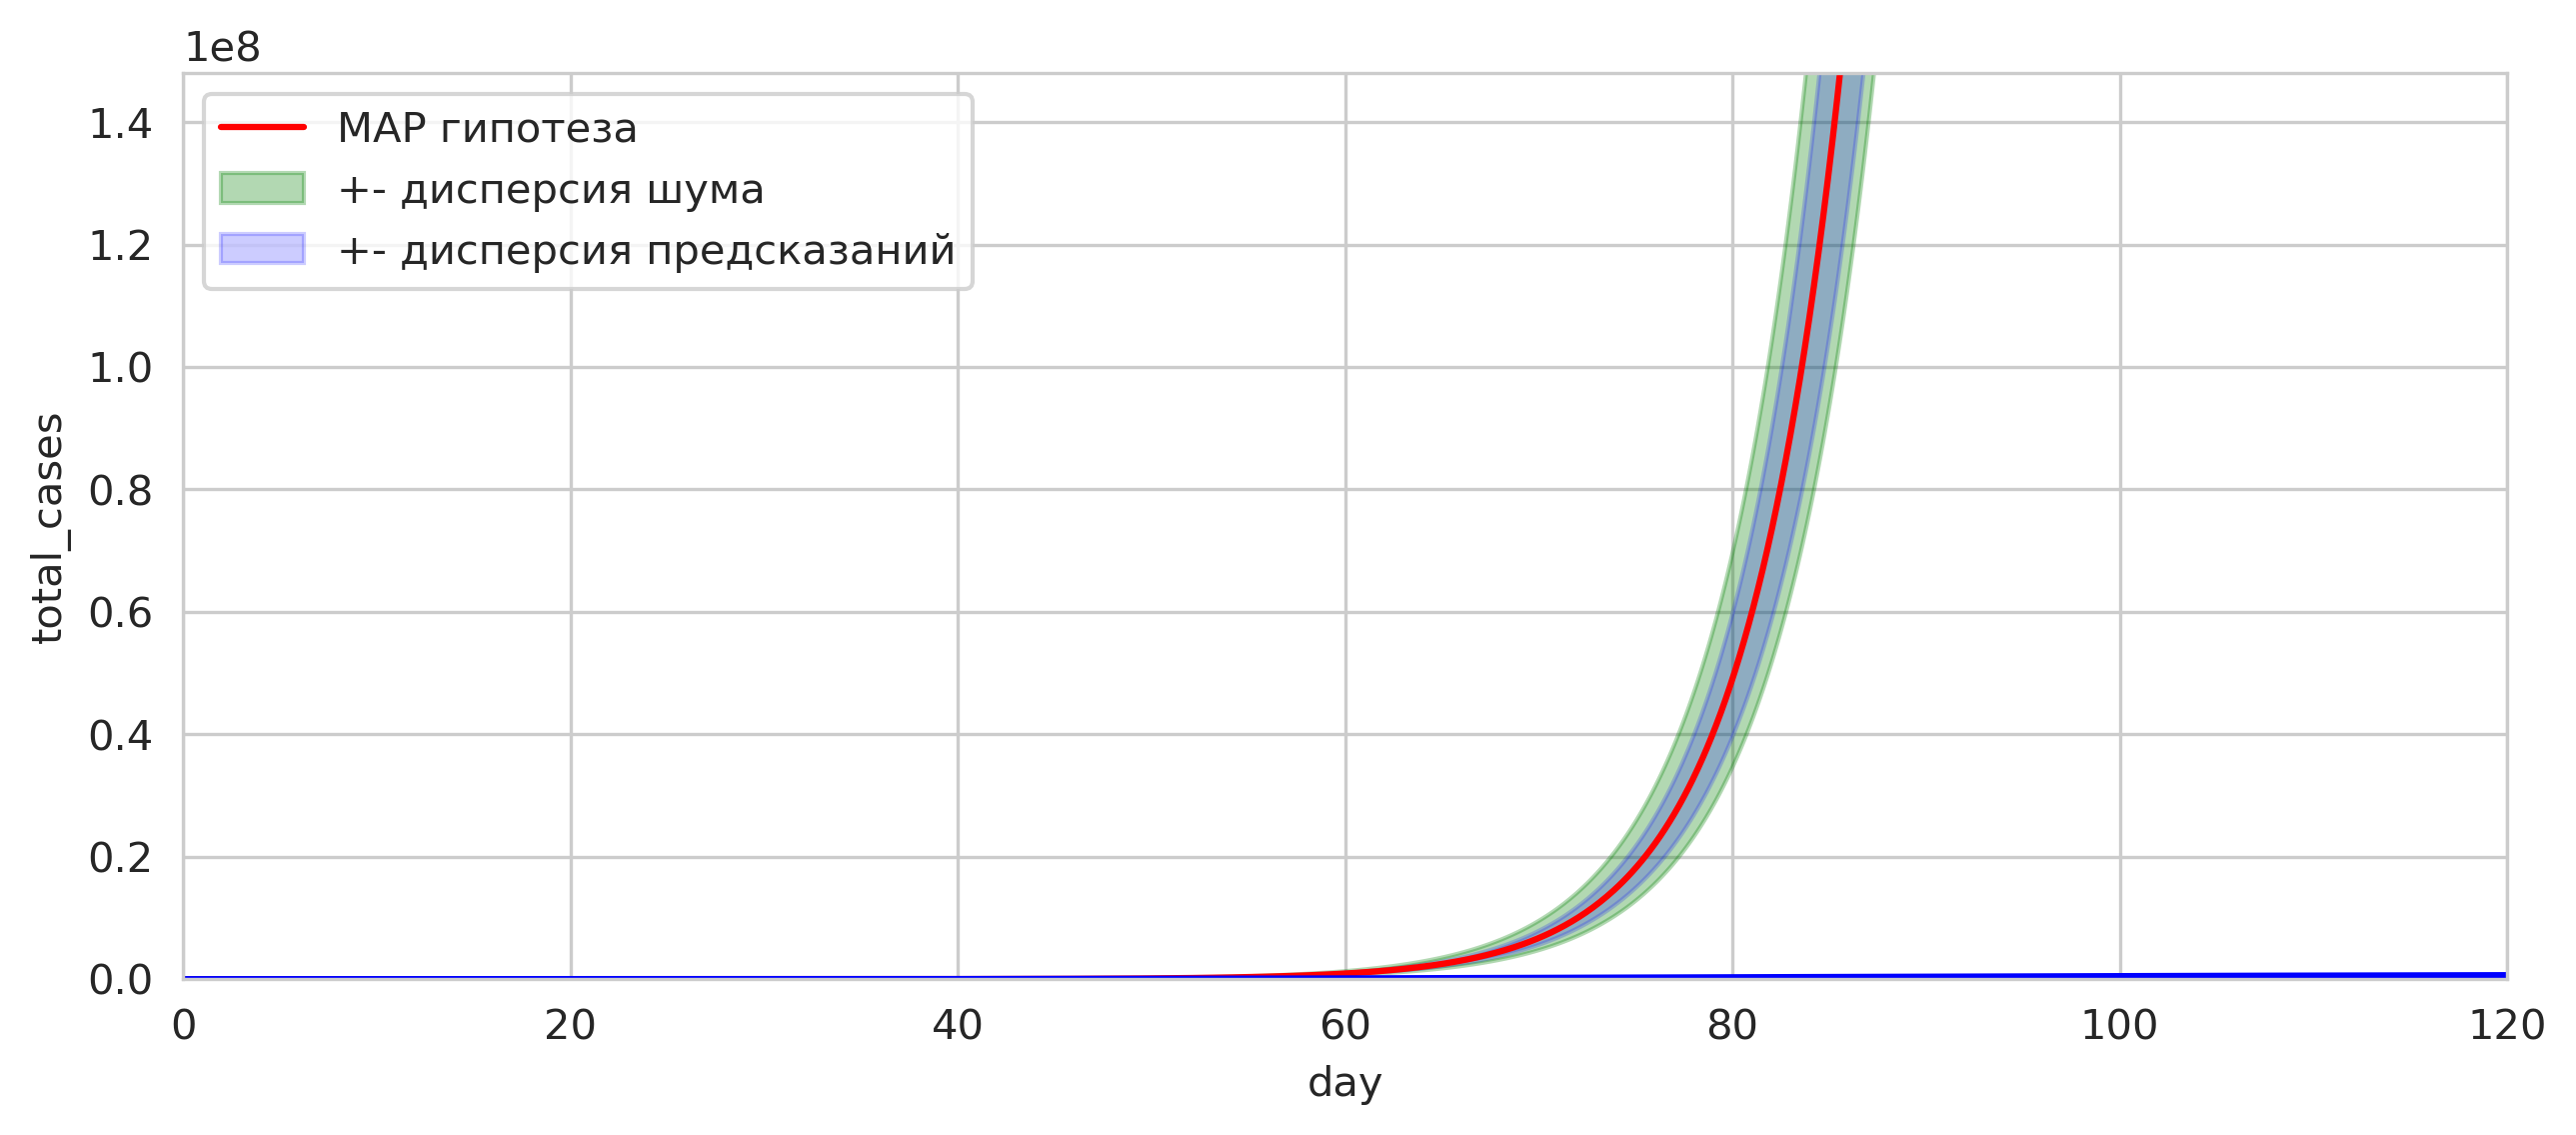

In [253]:
def sample_statistics(mu, sigma, xs, n=1000):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.exp(w[0]*xs + w[1])
    return res

# Нарисуем результат
def plot_predictions(xs, mu, x, points=None):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((0, 1.48e8))
    ax.plot(xs, np.exp(mu[0]*xs + mu[1]), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.exp(mu[0]*xs + mu[1] - sigma_noise), np.exp(mu[0]*xs + mu[1] + sigma_noise), 
                    color='green', alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), 
                    color='blue', alpha=.2, label="+- дисперсия предсказаний")    
    ax.legend(fontsize=legend_fontsize)
    
xs = np.linspace(0, 120, 1000)
x = sample_statistics(new_mean, new_cov, xs, n=1000)
plot_predictions(xs, new_mean, x)
sns.lineplot(data=df, x="day", y="total_cases", color='blue')

## Часть II.3
* Интеграл - это площадь под графиком, а общее число заболевших - это сумма заболевших по дням. Получается, чтобы приблизить число заболевших интегралом, можно приблизить функцию числа заболевших тем, что стоит под интегралом.
* Для обучения лин регресии и надо будет заменить 0 на 1(чтобы не было проблем при взятии логарифма)
* Чтобы обучить квадратичную функцию необходимо ввести соответсвующий признак (day**2)

In [254]:
df['day_square'] = df.day * df.day
df.new_cases = df.new_cases.replace({0: 1})
train = df.iloc[:50]
test = df.iloc[50:]
train.head()

,total_cases,new_cases,const,date,day,day_square
0,3.0,1.0,1,2020-03-03,0,0
1,3.0,1.0,1,2020-03-04,1,1
2,4.0,1.0,1,2020-03-05,2,4
3,13.0,9.0,1,2020-03-06,3,9
4,13.0,1.0,1,2020-03-07,4,16


In [255]:
X_train = train[['day_square', 'day', 'const']]
y_train = np.log(train.new_cases)
model = Ridge(alpha = 0.1, fit_intercept=False)
model.fit(X_train, y_train)
model.coef_

array([-0.0018202 ,  0.2750583 , -0.38973801])

In [256]:
#оценка байесовского шума
sigma_noise = np.std(y_train - model.predict(X_train))
sigma_noise

0.48917469839808875

In [257]:
#априорное распределение параметров
mean = np.zeros(3)
cov = np.identity(3)

In [258]:
#постериорное распределение параметров
new_mean, new_cov = bayesian_update(mean, cov, X_train, y_train, sigma_noise)
new_mean, new_cov

(array([-0.00180733,  0.27430174, -0.38056089]),
 array([[ 1.35245917e-07, -6.59759454e-06,  5.20456602e-05],
        [-6.59759454e-06,  3.44514702e-04, -3.09165883e-03],
        [ 5.20456602e-05, -3.09165883e-03,  3.82694116e-02]]))

In [288]:
def sample_statistics(mu, sigma, xs, n=1000):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.cumsum(np.exp(w[0]*xs*xs + w[1]*xs + w[2]))
    return res

xs = np.linspace(0, 1000, 1000)
x = sample_statistics(new_mean, new_cov, xs, n=1000)

<AxesSubplot:xlabel='day', ylabel='total_cases'>

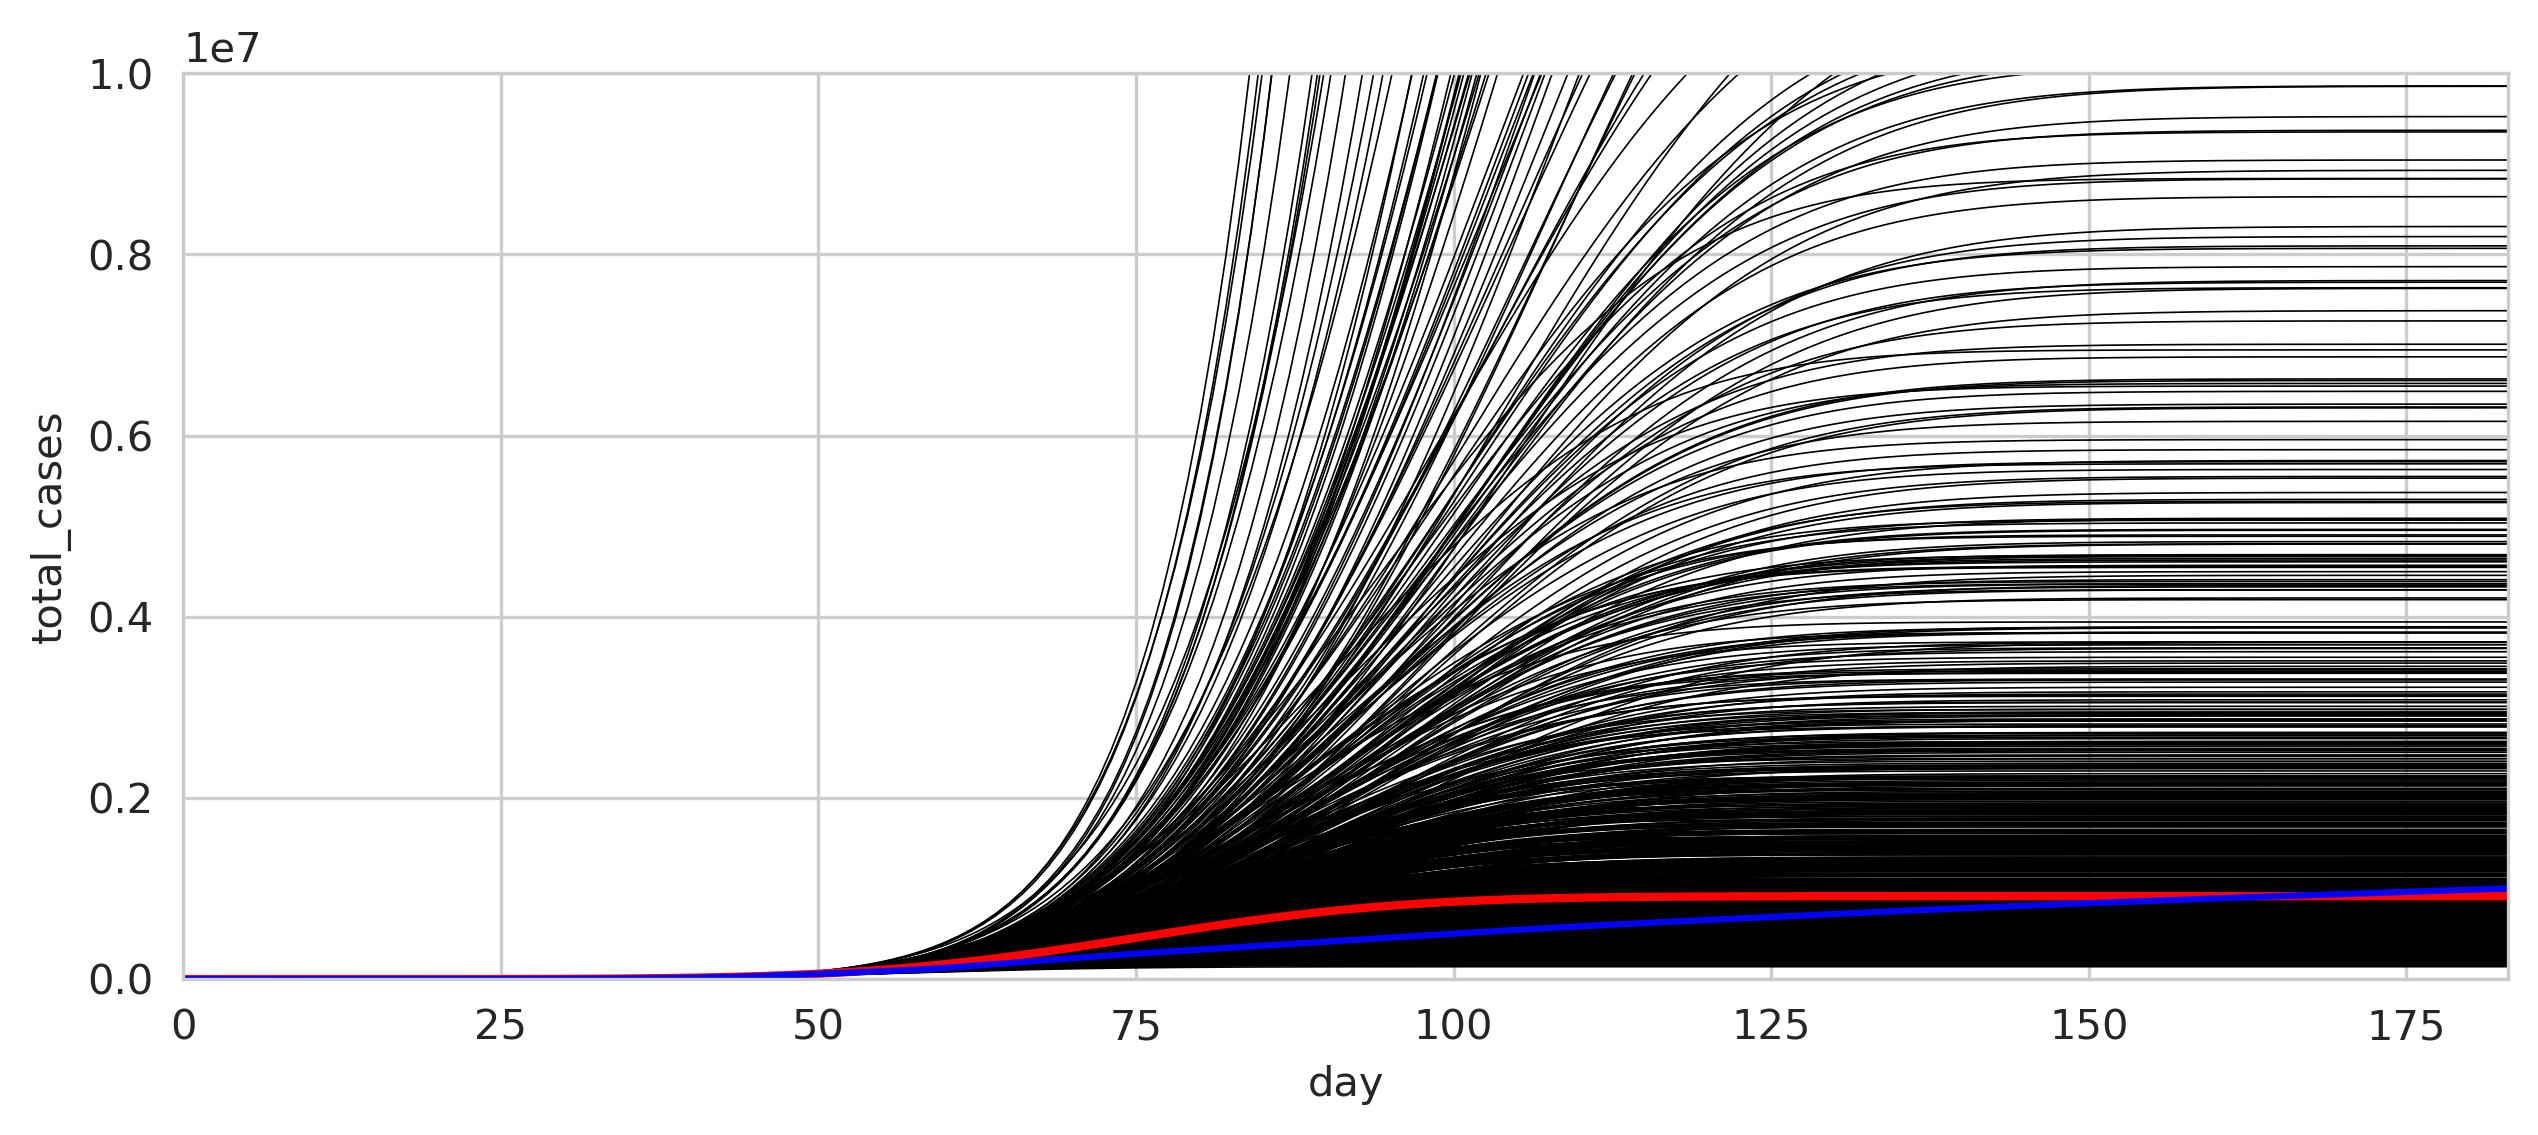

In [289]:
def myplot_sample_lines(x, points=None):
    for sample in x:
        plt.plot(xs, sample, 'k-', lw=.4)
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)


fig = plt.figure(figsize=(10, 4))
plt.ylim((0, 1e7))
plt.xlim((xs[0], 183))
myplot_sample_lines(x)
#MLE prediction
plt.plot(xs, np.cumsum(np.exp(model.coef_[0]*xs*xs + model.coef_[1]*xs + model.coef_[2])), lw=2, color='red')
sns.lineplot(data=df, x="day", y="total_cases", color='blue')

In [290]:
def get_pred(date):
    day = df[df.date == pd.to_datetime(date)].day
    pred = round(np.mean(x[:, day]))
    print(date, day.iloc[0], pred)
                                       

dates = ['2020-05-01', '2020-06-01', '2020-09-01']

for date in dates:
    get_pred(date)

2020-05-01 59 161348
2020-06-01 90 1293667
2020-09-01 182 22479177


<AxesSubplot:xlabel='day', ylabel='total_cases'>

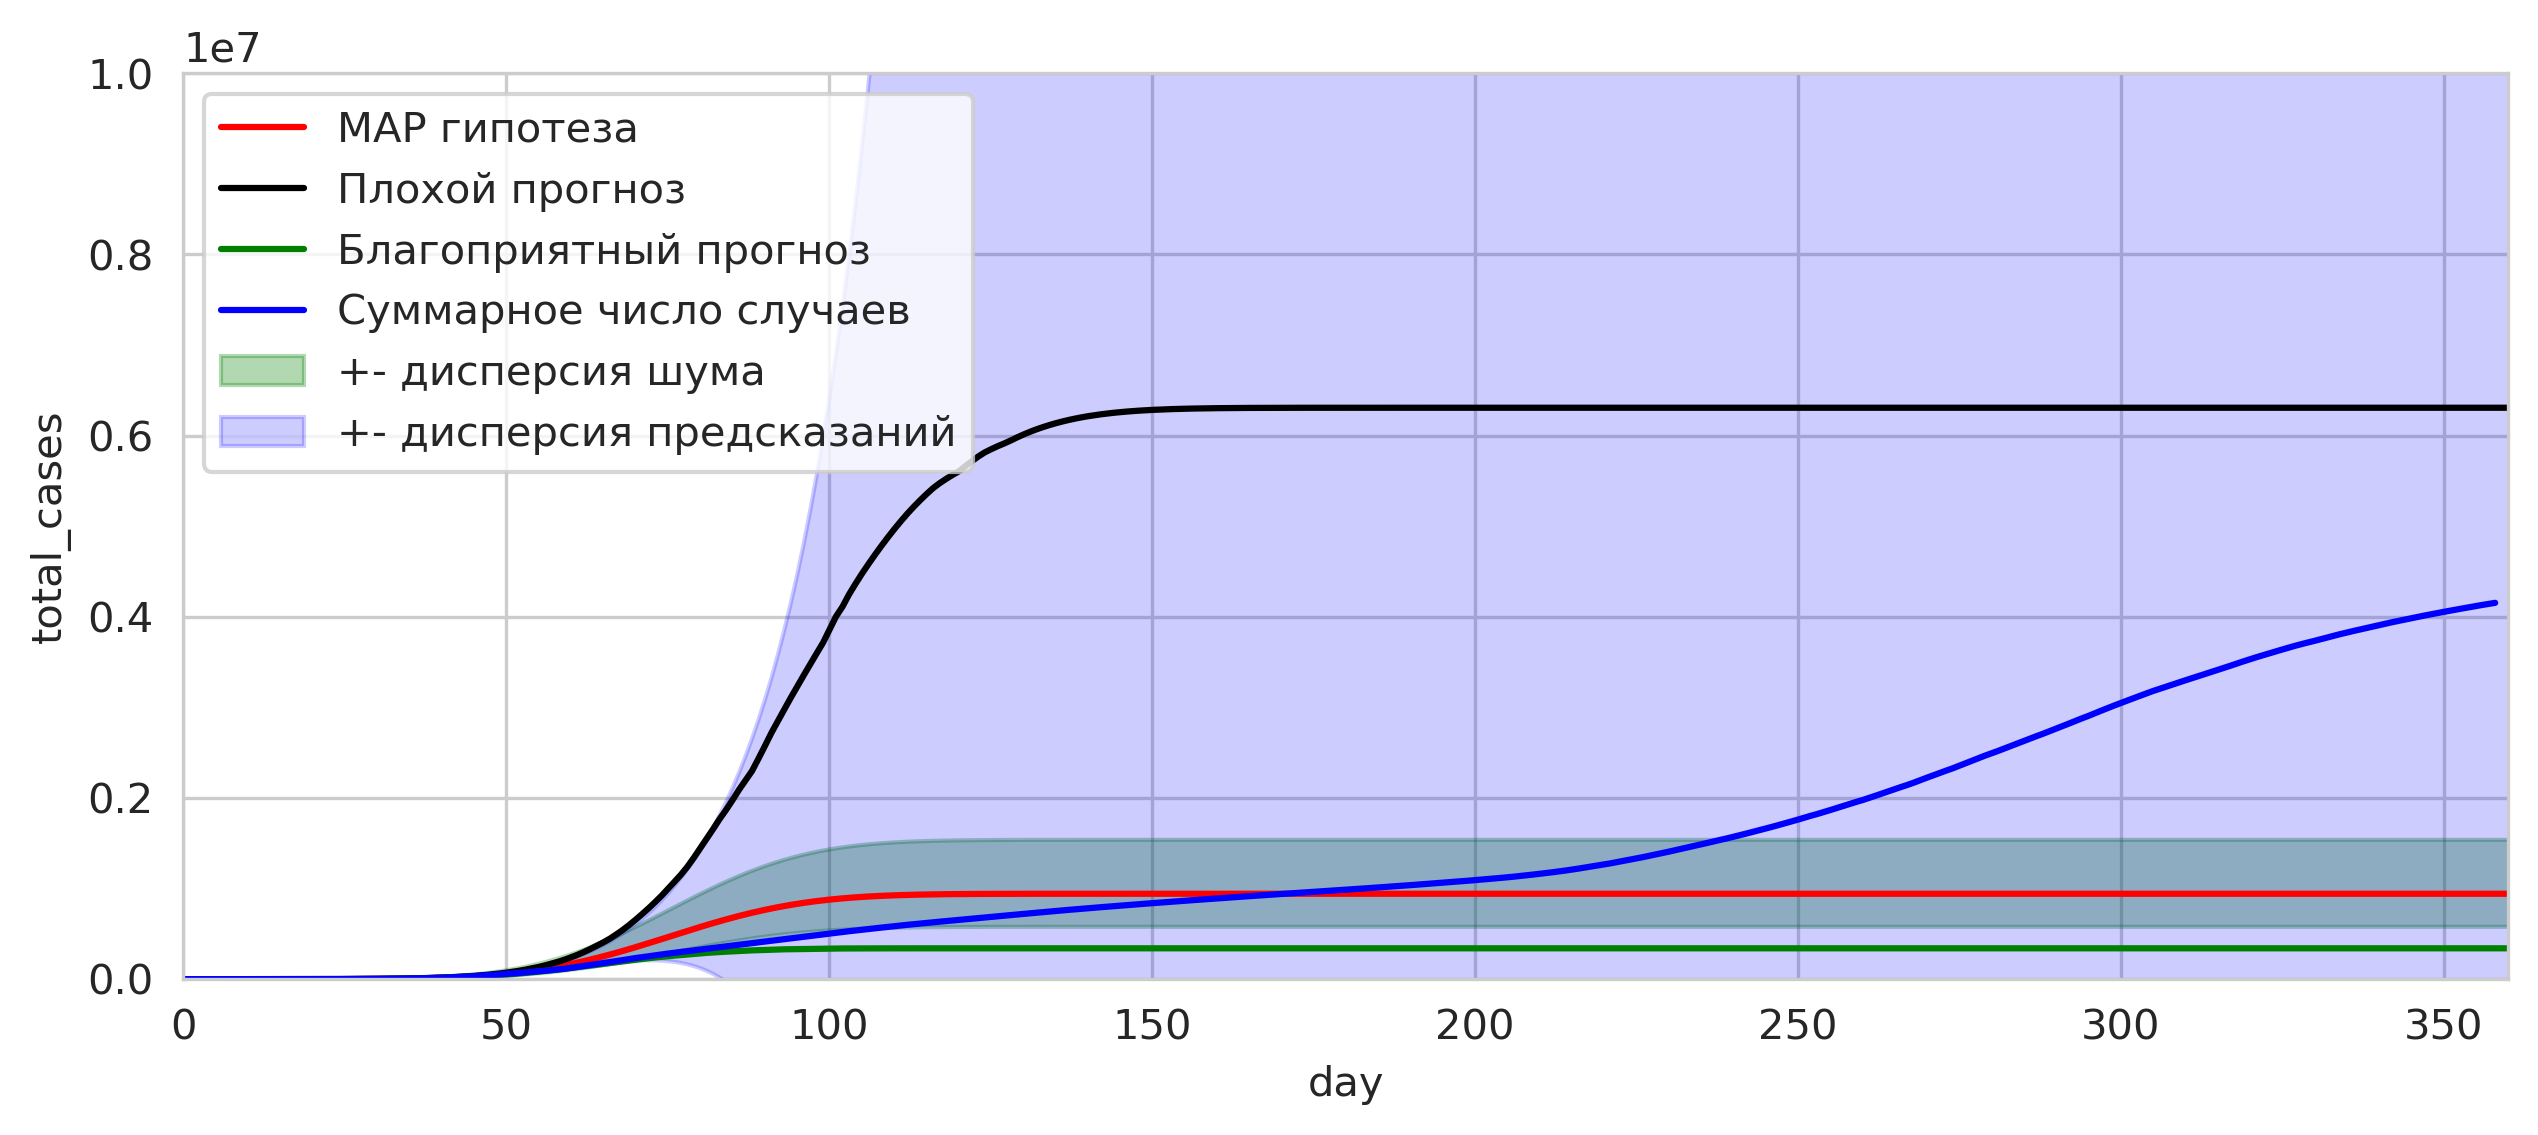

In [304]:
# Нарисуем результат
def plot_predictions(xs, mu, x, points=None):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], 360))
    ax.set_ylim((0, 1e7))
    ax.plot(xs, np.cumsum(np.exp(mu[0]*xs*xs + mu[1]*xs + mu[2])), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.cumsum(np.exp(mu[0]*xs*xs + mu[1]*xs + mu[2] - sigma_noise)), 
                    np.cumsum(np.exp(mu[0]*xs*xs + mu[1]*xs + mu[2] + sigma_noise)), 
                    color='green', alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), 
                    color='blue', alpha=.2, label="+- дисперсия предсказаний") 
    
    ax.plot(xs, np.quantile(x, 0.9, axis=0), color="black", label="Плохой прогноз")
    ax.plot(xs, np.quantile(x, 0.1, axis=0), color="green", label="Благоприятный прогноз")
    ax.legend(fontsize=legend_fontsize)
    
plot_predictions(xs, new_mean, x)
sns.lineplot(data=df, x="day", y="total_cases", color='blue', label="Суммарное число случаев")

In [295]:
pred = x[:, 999]
print('Благоприятный прогноз:', round(np.quantile(pred, 0.1)))
print('Неблагоприятный прогноз:', round(np.quantile(pred, 0.9)))

Благоприятный прогноз: 340650
Неблагоприятный прогноз: 6307161
